# The Battle of Neighborhoods in Europe: Choosing A City For Relocation
### By Sergei Perfilyev. June 2021
This notebook has been created for completing my capstone project for IBM/Coursera Applied Data Science specialization.

The code below is to implement the following tasks:
1. Collect, clean and prepare necessary data for our analysis. We are using several Python libraries including `Requests` for loading webpages, `BeautifulSoap` for parsing HTML, `Pandas` for tabular data processing, and etc. The objects to explore are: major European cities and top-ranked European universities. 
2. Obtain geographical coordinates of various objects for further analysis. This is done with `GeoPy` library via HERE.COM API geocoder.
3. Visualize the results of our analysis using `Foluim` library for building geographical maps.
4. For the cities of interest, load info on recommended venues and their categorical distribution. This will be done with Foursquare REST API.
5. Prepare the data for processing and apply a clustering algorithm in order to group cities in partitions. We are using K-meand clustering method and `scikit-learn` Python package.

## 1.1. Install and import libraries for data preparation and processing

In [2]:
# Install BeautifulSoup library, we'll use it for HTML parsing
!conda install -c conda-forge bs4 --yes

Solving environment: done

# All requested packages already installed.



In [3]:
from bs4 import BeautifulSoup
import requests as rq
from requests.auth import HTTPDigestAuth
import json
import pandas as pd
import numpy as np
import re
from sklearn.cluster import KMeans

In [4]:
# Read my keys, passwords and secrets for various APIs and websites
with open('my_secrets.json', 'r') as infile:
    my_secrets = json.load(infile)

In [5]:
# Define a function to handle http responses
def get_html(response: rq.models.Response):
    if response.status_code // 100 == 2:
        print('HTTP request OK!')
        return response.text
    else:
        print('HTTP request failed!')
        return None

## 1.2. Prepare a dataset of European Union (EU) member countries

In [6]:
# Let's get data from Eurostat official website
url_countries = "https://ec.europa.eu/eurostat/statistics-explained/index.php/Glossary:Country_codes"
html_countries = get_html(rq.get(url_countries))

# Parse web page and create a data frame containing all countries in the European Union (EU)
if html_countries:
    soup = BeautifulSoup(html_countries)
    cells = [cell.text.strip() for cell in soup.find('table').find_all('td')]
    df_countries = pd.DataFrame(data={'Code': cells[1::2], 'Country': cells[0::2]})
    df_countries.sort_values(by=['Country'], inplace=True, ignore_index=True)
    df_countries.Code = df_countries.Code.apply(lambda x: re.sub(r'[()]', '', x))
    df_countries.loc[df_countries.Country == 'Czechia', 'Country'] = 'Czech Republic'
    df_countries.set_index('Country', inplace=True)

HTTP request OK!


In [7]:
df_countries

,Code
Country,
Austria,AT
Belgium,BE
Bulgaria,BG
Croatia,HR
Cyprus,CY
Czech Republic,CZ
Denmark,DK
Estonia,EE
Finland,FI


## 1.3. Prepare a dataset of EU top universities

In [8]:
# Define a function to request data from Times Higher Educations's website
# Use my credentials for authentication
request_TimesHE = lambda url: rq.get(
    url,
    auth=HTTPDigestAuth(my_secrets['TIMES_HE']['LOGIN'], my_secrets['TIMES_HE']['PASSWORD']),
    headers={'user-agent': 'Mozilla/5.0'}
)

In [9]:
# Let's get data from Times Higher Education's website
url_univ = "https://www.timeshighereducation.com/student/best-universities/best-universities-europe"
html_univ = get_html(request_TimesHE(url_univ))

# Parse web page and create a data frame containing top european universities
if html_univ:
    univs = BeautifulSoup(html_univ).find('table').find_all('tr')
    df_univs = pd.DataFrame()
    for row in univs[1::]:
        row_cells = [cell.text.strip() for cell in row.find_all('td')]
        row_cells = row_cells[1:4] + [row.find('a').get('href')]
        df_univs = df_univs.append([row_cells], ignore_index=True)
    df_univs.columns = ['Rank', 'University', 'Country', 'URL']
    df_univs.set_index('Country', inplace=True)
    print(df_univs.shape)

HTTP request OK!
(531, 3)


In [10]:
df_univs.head(10)

,Rank,University,URL
Country,,,
United Kingdom,1,University of Oxford,https://www.timeshighereducation.com/world-uni...
United Kingdom,2,University of Cambridge,https://www.timeshighereducation.com/world-uni...
United Kingdom,3,Imperial College London,https://www.timeshighereducation.com/world-uni...
Switzerland,4,ETH Zurich,https://www.timeshighereducation.com/world-uni...
United Kingdom,5,UCL,https://www.timeshighereducation.com/world-uni...
United Kingdom,6,London School of Economics and Political Science,https://www.timeshighereducation.com/world-uni...
United Kingdom,7,University of Edinburgh,https://www.timeshighereducation.com/world-uni...
Germany,8,LMU Munich,https://www.timeshighereducation.com/world-uni...
United Kingdom,9,King’s College London,https://www.timeshighereducation.com/world-uni...


In [11]:
df_univs.tail(10)

,Rank,University,URL
Country,,,
Lithuania,=418,Vytautas Magnus University,https://www.timeshighereducation.com/world-uni...
Poland,=418,Warsaw University of Life Sciences – SGGW,https://www.timeshighereducation.com/world-uni...
Poland,=418,Warsaw University of Technology,https://www.timeshighereducation.com/world-uni...
Czech Republic,=418,University of West Bohemia,https://www.timeshighereducation.com/world-uni...
Poland,=418,Wrocław University of Environmental and Life S...,https://www.timeshighereducation.com/world-uni...
Poland,=418,Wrocław University of Science and Technology,https://www.timeshighereducation.com/world-uni...
Poland,=418,University of Wrocław,https://www.timeshighereducation.com/world-uni...
Ukraine,=418,Yuriy Fedkovych Chernivtsi National University,https://www.timeshighereducation.com/world-uni...
Croatia,=418,University of Zagreb,https://www.timeshighereducation.com/world-uni...


In [12]:
# Select top universities from the countries included in the EU
TOP_TO_SEARCH = 200
df_eu_univs = df_countries.join(df_univs, how='inner').reset_index()
df_eu_univs.Rank = pd.to_numeric(df_eu_univs.Rank.str.replace('=', ''))
df_eu_univs = df_eu_univs.sort_values(by='Rank', ignore_index=True).head(TOP_TO_SEARCH)
df_eu_univs.head(10)

,Country,Code,Rank,University,URL
0,Germany,DE,8,LMU Munich,https://www.timeshighereducation.com/world-uni...
1,Sweden,SE,10,Karolinska Institute,https://www.timeshighereducation.com/world-uni...
2,Germany,DE,11,Technical University of Munich,https://www.timeshighereducation.com/world-uni...
3,Germany,DE,12,Heidelberg University,https://www.timeshighereducation.com/world-uni...
4,Belgium,BE,14,KU Leuven,https://www.timeshighereducation.com/world-uni...
5,France,FR,15,Paris Sciences et Lettres – PSL Research Unive...,https://www.timeshighereducation.com/world-uni...
6,Netherlands,NL,17,Wageningen University & Research,https://www.timeshighereducation.com/world-uni...
7,Netherlands,NL,18,University of Amsterdam,https://www.timeshighereducation.com/world-uni...
8,Netherlands,NL,19,Leiden University,https://www.timeshighereducation.com/world-uni...
9,Netherlands,NL,20,Erasmus University Rotterdam,https://www.timeshighereducation.com/world-uni...


In [13]:
df_eu_univs.tail(10)

,Country,Code,Rank,University,URL
190,Czech Republic,CZ,279,Masaryk University,https://www.timeshighereducation.com/world-uni...
191,Greece,EL,279,University of Thessaly,https://www.timeshighereducation.com/world-uni...
192,Greece,EL,279,Athens University of Economics and Business,https://www.timeshighereducation.com/world-uni...
193,Austria,AT,279,Johannes Kepler University of Linz,https://www.timeshighereducation.com/world-uni...
194,Austria,AT,279,University of Graz,https://www.timeshighereducation.com/world-uni...
195,Germany,DE,279,Hamburg University of Technology,https://www.timeshighereducation.com/world-uni...
196,Germany,DE,279,University of Kaiserslautern,https://www.timeshighereducation.com/world-uni...
197,Portugal,PT,279,University of Aveiro,https://www.timeshighereducation.com/world-uni...
198,Portugal,PT,279,University of Beira Interior,https://www.timeshighereducation.com/world-uni...
199,Portugal,PT,279,University of Coimbra,https://www.timeshighereducation.com/world-uni...


In [14]:
df_eu_univs.drop(df_eu_univs.columns[0], axis=1, inplace=True)
df_eu_univs.to_csv('top_eu_univs.csv')

In [15]:
# Parse detailed webpages and get addresses of all universities into a list of strings
details = [''] * df_eu_univs.shape[0]
for i in df_eu_univs.index:
    html_univ_detail = get_html(request_TimesHE(df_eu_univs.loc[i, "URL"]))
    if html_univ_detail:
        print(i, ': Details downloaded OK!')
        soup = BeautifulSoup(html_univ_detail)
        details[i] = soup.find(class_="institution-info__contact-detail institution-info__contact-detail--address").text.strip()
    else:
        print(i, ': Could not download details!')

HTTP request OK!
0 : Details downloaded OK!
HTTP request OK!
1 : Details downloaded OK!
HTTP request OK!
2 : Details downloaded OK!
HTTP request OK!
3 : Details downloaded OK!
HTTP request OK!
4 : Details downloaded OK!
HTTP request OK!
5 : Details downloaded OK!
HTTP request OK!
6 : Details downloaded OK!
HTTP request OK!
7 : Details downloaded OK!
HTTP request OK!
8 : Details downloaded OK!
HTTP request OK!
9 : Details downloaded OK!
HTTP request OK!
10 : Details downloaded OK!
HTTP request OK!
11 : Details downloaded OK!
HTTP request OK!
12 : Details downloaded OK!
HTTP request OK!
13 : Details downloaded OK!
HTTP request OK!
14 : Details downloaded OK!
HTTP request OK!
15 : Details downloaded OK!
HTTP request OK!
16 : Details downloaded OK!
HTTP request OK!
17 : Details downloaded OK!
HTTP request OK!
18 : Details downloaded OK!
HTTP request OK!
19 : Details downloaded OK!
HTTP request OK!
20 : Details downloaded OK!
HTTP request OK!
21 : Details downloaded OK!
HTTP request OK!
22 

In [16]:
print(details)

['Geschwister-Scholl-Platz 1, Munich, 80539, Germany', 'SE-171 77, Stockholm, Sweden', 'Arcisstraße 21, Munich, D-80333, Germany', '310 E. Market Street, Tiffin, Ohio, 44883, United States', 'Oude Markt 13, Leuven, 3000, Belgium', '60 rue Mazarine, Paris, 75006, France', 'Droevendaalsesteeg 4, Building nr. 104, Wageningen, 6702 PB, Netherlands', 'P.O. Box 19268, 1000 GG Amsterdam, Netherlands', 'PO Box 9500, Leiden, 2300, Netherlands', 'Burgemeester Oudlaan 50, Rotterdam, 3062 PA, Netherlands', 'Charitéplatz 1, 10117 Berlin, Germany', 'P.O Box 80125, TC Utrecht, 3508, Netherlands', 'Postbus 5, 2600 AA Delft, Netherlands', 'Geschwister-Scholl-Platz, Tubingen, 72074, Germany', 'Unter den Linden 6, D-10099 Berlin, Germany', 'PO Box 72, 9700 AB Groningen, Netherlands', 'Fahnenbergplatz, 79085 Freiburg, Germany', 'Nørregade 10 Postboks 2177, 1017 København K, Denmark', 'Route de Saclay, Palaiseau, 91128, France', "21 Rue de l'Ecole-de-Medecine, Paris, 75006, France", 'P.O. Box 4, (Yliopisto

In [17]:
# Append addresses as a new column to the dataset
df_eu_univs['Address'] = details
df_eu_univs.head()

,Code,Rank,University,URL,Address
0,DE,8,LMU Munich,https://www.timeshighereducation.com/world-uni...,"Geschwister-Scholl-Platz 1, Munich, 80539, Ger..."
1,SE,10,Karolinska Institute,https://www.timeshighereducation.com/world-uni...,"SE-171 77, Stockholm, Sweden"
2,DE,11,Technical University of Munich,https://www.timeshighereducation.com/world-uni...,"Arcisstraße 21, Munich, D-80333, Germany"
3,DE,12,Heidelberg University,https://www.timeshighereducation.com/world-uni...,"310 E. Market Street, Tiffin, Ohio, 44883, Uni..."
4,BE,14,KU Leuven,https://www.timeshighereducation.com/world-uni...,"Oude Markt 13, Leuven, 3000, Belgium"


In [18]:
df_eu_univs.tail()

,Code,Rank,University,URL,Address
195,DE,279,Hamburg University of Technology,https://www.timeshighereducation.com/world-uni...,"Am Schwarzenberg, Hamburg, 21073, Germany"
196,DE,279,University of Kaiserslautern,https://www.timeshighereducation.com/world-uni...,"Gottlieb-Daimler-Strasse, Kaiserslautern, 6766..."
197,PT,279,University of Aveiro,https://www.timeshighereducation.com/world-uni...,"Aveiro, 3810-193, Portugal"
198,PT,279,University of Beira Interior,https://www.timeshighereducation.com/world-uni...,"Convento de Sto. Antonio, 6201-001 Covilha, Po..."
199,PT,279,University of Coimbra,https://www.timeshighereducation.com/world-uni...,"Paço das Escolas, Coimbra, 3004-531, Portugal"


In [19]:
df_eu_univs.to_csv('top_eu_univs.csv')
#df_eu_univs = pd.read_csv('top_eu_univs.csv')

## 1.4. Prepare a dataset of EU major cities

In [21]:
# Create list of cities in EU (parse Wikipedia page)
url_cities = "https://en.wikipedia.org/wiki/List_of_cities_in_the_European_Union_by_population_within_city_limits"
html_cities = get_html(rq.get(url_cities))

if html_cities:
    cities = BeautifulSoup(html_cities).find('table')
    df_cities = pd.DataFrame()
    for row in cities.find_all('tr')[1::]:
        cells = [c.text.strip() for c in row.find_all('td')[1:4]]
        df_cities = df_cities.append([cells], ignore_index=True)
    df_cities.columns = ['City', 'Country', 'Population']
    df_cities.Population = pd.to_numeric(df_cities.Population.str.replace(',', ''))
    print(df_cities.dtypes)
    print(df_cities.shape)

HTTP request OK!
City          object
Country       object
Population     int64
dtype: object
(93, 3)


In [22]:
df_cities.head(10)

,City,Country,Population
0,Berlin,Germany,3669495
1,Madrid,Spain,3348536
2,Rome,Italy,2856133
3,Bucharest,Romania,2155240
4,Paris,France,2140526
5,Vienna,Austria,1921153
6,Hamburg,Germany,1899160
7,Warsaw,Poland,1793579
8,Budapest,Hungary,1752286
9,Barcelona,Spain,1620343


In [23]:
df_cities.tail(10)

,City,Country,Population
83,Cluj-Napoca,Romania,324960
84,Bari,Italy,320862
85,Constanța,Romania,317832
86,Münster,Germany,314319
87,Karlsruhe,Germany,313092
88,Catania,Italy,311584
89,Mannheim,Germany,309370
90,Nantes,France,306694
91,Craiova,Romania,305386
92,Galați,Romania,304050


## 2.1. Geocode our datasets: cities

In [24]:
# Install and import libraries for geocoding
!conda install -c conda-forge geopy --yes
from geopy.geocoders import Here
from geopy import distance
from geopy.location import Location

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.52         |     pyhd8ed1ab_0          35 KB  conda-forge
    geopy-2.1.0                |     pyhd3deb0d_0          64 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          99 KB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.52-pyhd8ed1ab_0
  geopy              conda-forge/noarch::geopy-2.1.0-pyhd3deb0d_0



geographiclib-1.52   | 35 KB     | ##################################### | 100% 
geopy-2.1.0          | 64 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transa

In [25]:
# Initialize a geocoder
geocoder = Here(apikey=my_secrets['HERE']['API_KEY'])

In [26]:
# Obtain pair of geo coords (Lat, Lon) for a chosen object defined by a name
# Return (None, None) if geocoder fails
def get_location(location_name: str):
    location = geocoder.geocode(location_name)
    if location is None:
        print('Cannot geocode specified object:', location_name)
        return (None, None)
    else:
        print(f"{location.address} = {location.latitude}, {location.longitude}")
        return (location.latitude, location.longitude)

In [27]:
# Obtain geo coords (Lat, Lon) for a chosen dataframe, append two columns 'Lat' and 'Lon'
def geocode_dataframe(df_to_modify, address_fields):
    geo_lats, geo_lons = zip(*[
        get_location(','.join([df_to_modify.loc[i, f] for f in address_fields])) for i in df_to_modify.index
    ])
    df_to_modify['Lat'] = geo_lats[:]
    df_to_modify['Lon'] = geo_lons[:]

In [28]:
# Geocode all EU cities
geocode_dataframe(df_cities, address_fields = ['City', 'Country'])

Berlin, Deutschland, Berlin, Berlin 10117, DEU = 52.51605, 13.37691
Madrid, Comunidad de Madrid, España, Madrid, Comunidad de Madrid 28014, ESP = 40.41956, -3.69196
Roma, Lazio, Italia, Roma, Lazio 00185, ITA = 41.90323, 12.49566
București, România, București 030171, ROU = 44.4343, 26.10298
Paris, Île-de-France, France, Paris, Île-de-France 75001, FRA = 48.85718, 2.34141
Wien, Österreich, Wien, Wien 1010, AUT = 48.20263, 16.36843
Hamburg, Deutschland, Hamburg, Hamburg 20354, DEU = 53.55562, 9.98746
Warszawa, Woj. Mazowieckie, Polska, Warszawa, Woj. Mazowieckie 00-941, POL = 52.2356, 21.01038
Budapest, Magyarország, Budapest, Budapest 1061, HUN = 47.49973, 19.05508
Barcelona, Catalunya, Espanya, Barcelona, Catalunya 08007, ESP = 41.38804, 2.17001
München, Bayern, Deutschland, München, Bayern 80331, DEU = 48.13642, 11.57755
Milano, Lombardia, Italia, Milano, Lombardia 20121, ITA = 45.46796, 9.18178
Praha, Hlavní město Praha, Česká Republika, Praha, Hlavní město Praha 120 00, CZE = 50.079

In [29]:
df_cities.head(10)

,City,Country,Population,Lat,Lon
0,Berlin,Germany,3669495,52.51605,13.37691
1,Madrid,Spain,3348536,40.41956,-3.69196
2,Rome,Italy,2856133,41.90323,12.49566
3,Bucharest,Romania,2155240,44.43430,26.10298
4,Paris,France,2140526,48.85718,2.34141
5,Vienna,Austria,1921153,48.20263,16.36843
6,Hamburg,Germany,1899160,53.55562,9.98746
7,Warsaw,Poland,1793579,52.23560,21.01038
8,Budapest,Hungary,1752286,47.49973,19.05508
9,Barcelona,Spain,1620343,41.38804,2.17001


In [30]:
df_cities.tail(10)

,City,Country,Population,Lat,Lon
83,Cluj-Napoca,Romania,324960,46.76870,23.58503
84,Bari,Italy,320862,41.12588,16.86666
85,Constanța,Romania,317832,44.17827,28.65116
86,Münster,Germany,314319,51.96302,7.61782
87,Karlsruhe,Germany,313092,49.01094,8.40846
88,Catania,Italy,311584,37.51136,15.06752
89,Mannheim,Germany,309370,49.48651,8.46679
90,Nantes,France,306694,47.21812,-1.55306
91,Craiova,Romania,305386,44.32020,23.79895
92,Galați,Romania,304050,45.43369,28.05476


In [31]:
df_cities.to_csv('top_eu_cities.csv')

## 2.2. Geocode our datasets: universities

In [32]:
# Geocode all EU universities
df_eu_univs = pd.read_csv('top_eu_univs.csv')
geocode_dataframe(df_eu_univs, address_fields = ['Address'])

Geschwister-Scholl-Platz 1, 80539 München, Deutschland, München, Bayern 80539, DEU = 48.1505, 11.5803
121 77, Stockholm, Stockholms län, Sverige, Stockholm, Stockholms län 121 77, SWE = 59.29349, 18.08222
Arcisstraße 21, 80333 München, Deutschland, München, Bayern 80333, DEU = 48.14885, 11.568
310 E Market St, Tiffin, OH 44883, United States, Tiffin, OH 44883, USA = 41.11633, -83.16853
Oude Markt 13, 3000 Leuven, België, Leuven, Vlaanderen 3000, BEL = 50.87794, 4.70032
60 Rue Mazarine, 75006 Paris, France, Paris, Île-de-France 75006, FRA = 48.85468, 2.3376
Droevendaalsesteeg 4, 6708 PB Wageningen, Nederland, Wageningen, Gelderland 6708 PB, NLD = 51.98633, 5.66794
Cannot geocode specified object: P.O. Box 19268, 1000 GG Amsterdam, Netherlands
Cannot geocode specified object: PO Box 9500, Leiden, 2300, Netherlands
Burgemeester Oudlaan 50, 3062 PA Rotterdam, Nederland, Rotterdam, Zuid-Holland 3062 PA, NLD = 51.91906, 4.52516
Charitéplatz 1, 10117 Berlin, Deutschland, Berlin, Berlin 10117,

In [33]:
df_eu_univs.head(10)

,Unnamed: 0,Code,Rank,University,URL,Address,Lat,Lon
0,0,DE,8,LMU Munich,https://www.timeshighereducation.com/world-uni...,"Geschwister-Scholl-Platz 1, Munich, 80539, Ger...",48.1505,11.5803
1,1,SE,10,Karolinska Institute,https://www.timeshighereducation.com/world-uni...,"SE-171 77, Stockholm, Sweden",59.2935,18.0822
2,2,DE,11,Technical University of Munich,https://www.timeshighereducation.com/world-uni...,"Arcisstraße 21, Munich, D-80333, Germany",48.1489,11.568
3,3,DE,12,Heidelberg University,https://www.timeshighereducation.com/world-uni...,"310 E. Market Street, Tiffin, Ohio, 44883, Uni...",41.1163,-83.1685
4,4,BE,14,KU Leuven,https://www.timeshighereducation.com/world-uni...,"Oude Markt 13, Leuven, 3000, Belgium",50.8779,4.70032
5,5,FR,15,Paris Sciences et Lettres – PSL Research Unive...,https://www.timeshighereducation.com/world-uni...,"60 rue Mazarine, Paris, 75006, France",48.8547,2.3376
6,6,NL,17,Wageningen University & Research,https://www.timeshighereducation.com/world-uni...,"Droevendaalsesteeg 4, Building nr. 104, Wageni...",51.9863,5.66794
7,7,NL,18,University of Amsterdam,https://www.timeshighereducation.com/world-uni...,"P.O. Box 19268, 1000 GG Amsterdam, Netherlands",None,None
8,8,NL,19,Leiden University,https://www.timeshighereducation.com/world-uni...,"PO Box 9500, Leiden, 2300, Netherlands",None,None
9,9,NL,20,Erasmus University Rotterdam,https://www.timeshighereducation.com/world-uni...,"Burgemeester Oudlaan 50, Rotterdam, 3062 PA, N...",51.9191,4.52516


In [34]:
df_eu_univs.tail(10)

,Unnamed: 0,Code,Rank,University,URL,Address,Lat,Lon
190,190,CZ,279,Masaryk University,https://www.timeshighereducation.com/world-uni...,"Žerotínovo námestí 9 Rektorát, Brno-mesto, Brn...",49.1988,16.6052
191,191,EL,279,University of Thessaly,https://www.timeshighereducation.com/world-uni...,"Argonafton & Filellinon, 38221 Volos, Greece",39.3571,22.9509
192,192,EL,279,Athens University of Economics and Business,https://www.timeshighereducation.com/world-uni...,"76, Patission Str., GR10434 Athens, Greece",37.9761,23.7364
193,193,AT,279,Johannes Kepler University of Linz,https://www.timeshighereducation.com/world-uni...,"Altenberger Straße 69, A-4040 Linz, Austria",48.3373,14.3226
194,194,AT,279,University of Graz,https://www.timeshighereducation.com/world-uni...,"Universitätsplatz 3, A - 8010 Graz, Austria",47.0776,15.4495
195,195,DE,279,Hamburg University of Technology,https://www.timeshighereducation.com/world-uni...,"Am Schwarzenberg, Hamburg, 21073, Germany",53.4638,9.96976
196,196,DE,279,University of Kaiserslautern,https://www.timeshighereducation.com/world-uni...,"Gottlieb-Daimler-Strasse, Kaiserslautern, 6766...",49.4226,7.75349
197,197,PT,279,University of Aveiro,https://www.timeshighereducation.com/world-uni...,"Aveiro, 3810-193, Portugal",40.6341,-8.65799
198,198,PT,279,University of Beira Interior,https://www.timeshighereducation.com/world-uni...,"Convento de Sto. Antonio, 6201-001 Covilha, Po...",40.1998,-7.54486
199,199,PT,279,University of Coimbra,https://www.timeshighereducation.com/world-uni...,"Paço das Escolas, Coimbra, 3004-531, Portugal",40.3143,-8.75085


In [35]:
# See the records with unsuccessful geocoding
uncoded_univs = list(df_eu_univs[df_eu_univs.Lat.isna()].index)
uncoded_univs

[7, 8, 11, 41, 105, 107]

In [36]:
# Let's try to process the addresses where P.O.Boxes did not allow to geocode properly
for i in uncoded_univs:
    # if address contains P.O.Box then we remove this part of the address
    addr = df_eu_univs.Address[i].split(', ')
    for j in range(len(addr)):
        if re.search('Box [0-9]{3,}', addr[j]) or re.search('Postfach [0-9]*', addr[j]):
            addr[j] = ''
    df_eu_univs.loc[i, 'Lat'], df_eu_univs.loc[i, 'Lon'] = get_location(', '.join(addr))

Amsterdam, Noord-Holland, Nederland, Amsterdam, Noord-Holland 1011 MG, NLD = 52.36994, 4.90788
Leiden, Zuid-Holland, Nederland, Leiden, Zuid-Holland 2311, NLD = 52.15364, 4.49381
Utrecht, Nederland, Utrecht, Utrecht 3511, NLD = 52.08979, 5.11415
Bielefeld, Nordrhein-Westfalen, Deutschland, Bielefeld, Nordrhein-Westfalen 33604, DEU = 52.01548, 8.53232
Cannot geocode specified object: SE-901 87, Umea, Sweden
Cannot geocode specified object: SLU, , SE-750 07, Sweden


In [37]:
# See the results of this extra geocoding
df_eu_univs.iloc[uncoded_univs,]

,Unnamed: 0,Code,Rank,University,URL,Address,Lat,Lon
7,7,NL,18,University of Amsterdam,https://www.timeshighereducation.com/world-uni...,"P.O. Box 19268, 1000 GG Amsterdam, Netherlands",52.3699,4.90788
8,8,NL,19,Leiden University,https://www.timeshighereducation.com/world-uni...,"PO Box 9500, Leiden, 2300, Netherlands",52.1536,4.49381
11,11,NL,23,Utrecht University,https://www.timeshighereducation.com/world-uni...,"P.O Box 80125, TC Utrecht, 3508, Netherlands",52.0898,5.11415
41,41,DE,68,Bielefeld University,https://www.timeshighereducation.com/world-uni...,"Postfach 10 01 31, D-33501 Bielefeld, Germany",52.0155,8.53232
105,105,SE,164,Umeå University,https://www.timeshighereducation.com/world-uni...,"SE-901 87, Umea, Sweden",None,None
107,107,SE,164,Swedish University of Agricultural Sciences,https://www.timeshighereducation.com/world-uni...,"SLU, P.O. Box 7070, SE-750 07, Sweden",None,None


In [38]:
# Remove records that could not be geocoded eventually
df_eu_univs.dropna(axis=0, subset=['Lat', 'Lon'], inplace=True)
df_eu_univs.reset_index(drop=True, inplace=True)
print(df_eu_univs.shape)

(198, 8)


In [39]:
df_eu_univs.tail(10)

,Unnamed: 0,Code,Rank,University,URL,Address,Lat,Lon
188,190,CZ,279,Masaryk University,https://www.timeshighereducation.com/world-uni...,"Žerotínovo námestí 9 Rektorát, Brno-mesto, Brn...",49.1988,16.6052
189,191,EL,279,University of Thessaly,https://www.timeshighereducation.com/world-uni...,"Argonafton & Filellinon, 38221 Volos, Greece",39.3571,22.9509
190,192,EL,279,Athens University of Economics and Business,https://www.timeshighereducation.com/world-uni...,"76, Patission Str., GR10434 Athens, Greece",37.9761,23.7364
191,193,AT,279,Johannes Kepler University of Linz,https://www.timeshighereducation.com/world-uni...,"Altenberger Straße 69, A-4040 Linz, Austria",48.3373,14.3226
192,194,AT,279,University of Graz,https://www.timeshighereducation.com/world-uni...,"Universitätsplatz 3, A - 8010 Graz, Austria",47.0776,15.4495
193,195,DE,279,Hamburg University of Technology,https://www.timeshighereducation.com/world-uni...,"Am Schwarzenberg, Hamburg, 21073, Germany",53.4638,9.96976
194,196,DE,279,University of Kaiserslautern,https://www.timeshighereducation.com/world-uni...,"Gottlieb-Daimler-Strasse, Kaiserslautern, 6766...",49.4226,7.75349
195,197,PT,279,University of Aveiro,https://www.timeshighereducation.com/world-uni...,"Aveiro, 3810-193, Portugal",40.6341,-8.65799
196,198,PT,279,University of Beira Interior,https://www.timeshighereducation.com/world-uni...,"Convento de Sto. Antonio, 6201-001 Covilha, Po...",40.1998,-7.54486
197,199,PT,279,University of Coimbra,https://www.timeshighereducation.com/world-uni...,"Paço das Escolas, Coimbra, 3004-531, Portugal",40.3143,-8.75085


In [40]:
df_eu_univs.to_csv('top_eu_univs.csv')

## 2.3. Use location data to reduce number of cities to analyze
Now, we will narrow down our further analysis and exclude all the cities that do not have top-ranked universities located nearby.

That is, if the number of universities located in a specified range around the city (`CITY_UNIV_RADIUS`) is less than the specified minimum acceptable value (`UNIVS_IN_NEGHBORHOOD`), then the city will be excluded from our dataset.

In [41]:
# Calculate number of universities in radius of each city
CITY_UNIV_RADIUS = 50.0        # range in kilometers
UNIVS_IN_NEIGHBORHOOD = 1      # minimum acceptable numbers of universities around a city
city_has_univs = [0] * df_cities.shape[0]
for i in df_cities.index:
    univs_in_radius = 0
    for j in df_eu_univs.index:
        dist = distance.distance(
            (df_cities.Lat[i], df_cities.Lon[i]),
            (df_eu_univs.Lat[j], df_eu_univs.Lon[j])).km
        if dist <= CITY_UNIV_RADIUS:
            univs_in_radius += 1
    city_has_univs[i] = univs_in_radius
df_cities['HasUnivs'] = city_has_univs
df_cities.head(10)

,City,Country,Population,Lat,Lon,HasUnivs
0,Berlin,Germany,3669495,52.51605,13.37691,5
1,Madrid,Spain,3348536,40.41956,-3.69196,3
2,Rome,Italy,2856133,41.90323,12.49566,2
3,Bucharest,Romania,2155240,44.43430,26.10298,0
4,Paris,France,2140526,48.85718,2.34141,14
5,Vienna,Austria,1921153,48.20263,16.36843,3
6,Hamburg,Germany,1899160,53.55562,9.98746,2
7,Warsaw,Poland,1793579,52.23560,21.01038,0
8,Budapest,Hungary,1752286,47.49973,19.05508,1
9,Barcelona,Spain,1620343,41.38804,2.17001,3


In [42]:
df_cities.tail(10)

,City,Country,Population,Lat,Lon,HasUnivs
83,Cluj-Napoca,Romania,324960,46.76870,23.58503,0
84,Bari,Italy,320862,41.12588,16.86666,2
85,Constanța,Romania,317832,44.17827,28.65116,0
86,Münster,Germany,314319,51.96302,7.61782,1
87,Karlsruhe,Germany,313092,49.01094,8.40846,1
88,Catania,Italy,311584,37.51136,15.06752,1
89,Mannheim,Germany,309370,49.48651,8.46679,2
90,Nantes,France,306694,47.21812,-1.55306,3
91,Craiova,Romania,305386,44.32020,23.79895,0
92,Galați,Romania,304050,45.43369,28.05476,0


In [43]:
# Filter out cities with insufficient number of universities
df_cities = df_cities[df_cities.HasUnivs >= UNIVS_IN_NEIGHBORHOOD]
df_cities.reset_index(drop=True, inplace=True)
df_cities.shape

(60, 6)

In [44]:
df_cities.sort_values(by=['Population'], ascending=False, ignore_index=True)

,City,Country,Population,Lat,Lon,HasUnivs
0,Berlin,Germany,3669495,52.51605,13.37691,5
1,Madrid,Spain,3348536,40.41956,-3.69196,3
2,Rome,Italy,2856133,41.90323,12.49566,2
3,Paris,France,2140526,48.85718,2.34141,14
4,Vienna,Austria,1921153,48.20263,16.36843,3
5,Hamburg,Germany,1899160,53.55562,9.98746,2
6,Budapest,Hungary,1752286,47.49973,19.05508,1
7,Barcelona,Spain,1620343,41.38804,2.17001,3
8,Munich,Germany,1558395,48.13642,11.57755,2
9,Milan,Italy,1404239,45.46796,9.18178,6


In [45]:
df_cities.to_csv('top_eu_cities.csv')
#df_cities = pd.read_csv('top_eu_cities.csv')

## 2.4. The resulting dataset of EU cities
Now, let's take a look at how the cities of our interest are distributed in terms of size:

<AxesSubplot:ylabel='Population, million people'>

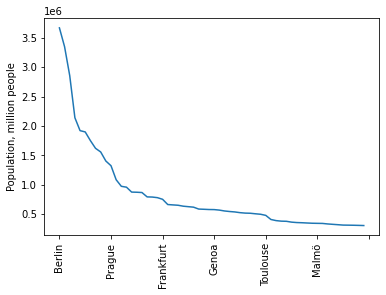

In [46]:
df_cities.plot(x='City', y='Population', xlabel='', ylabel='Population, million people', rot=90, legend=False)

<AxesSubplot:>

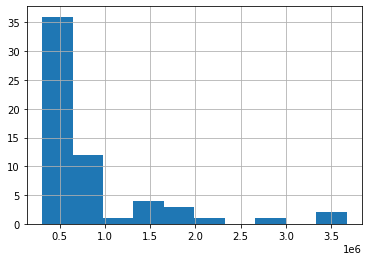

In [47]:
df_cities.Population.hist()

## 3. Visualizing the cities on a map
Now, let's see how the cities are located:

In [48]:
# Install Folium library to visualize cities on a map
!conda install -c conda-forge folium --yes
import folium
print('Folium installed and imported!')

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - folium


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    branca-0.4.2               |     pyhd8ed1ab_0          26 KB  conda-forge
    folium-0.12.0              |     pyhd8ed1ab_1          64 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          90 KB

The following NEW packages will be INSTALLED:

  branca             conda-forge/noarch::branca-0.4.2-pyhd8ed1ab_0
  folium             conda-forge/noarch::folium-0.12.0-pyhd8ed1ab_1



branca-0.4.2         | 26 KB     | ##################################### | 100% 
folium-0.12.0        | 64 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transacti

In [49]:
# Define the world map centered around Europe
location_center = df_cities.loc[df_cities['City'] == 'Munich', ['Lat', 'Lon']].values.tolist()[0]
map_europe = folium.Map(location=location_center, zoom_start=4)

# Create and fill a feature group for the cities in the dataframe
feat_cities = folium.map.FeatureGroup()
for lat, lon, label, popul in zip(df_cities.Lat, df_cities.Lon, df_cities.City, df_cities.Population):
    folium.Marker([lat, lon], popup=label).add_to(map_europe)
    feat_color = 'red' if popul >= 1_000_000 else 'yellow'
    feat_cities.add_child(
        folium.features.CircleMarker(
            [lat, lon],
            radius=5,
            color=feat_color,
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )
map_europe.add_child(feat_cities)
map_europe

## 4. Using Foursqare API to explore venues in the cities

In [50]:
# Define Foursquare API settings
API_VERSION = '20180605'    # API version
API_LIMIT = 100             # maximum records returned for one API request
API_RETRIES = 2             # how many times we retry an API request if an error occurs

In [51]:
# Define a function that explores all the neighborhoods/cities
from time import sleep
def get_nearby_venues(names, latitudes, longitudes, radius=500):

    venues_list = []
    for name, lat, lon in zip(names, latitudes, longitudes):

        need_venues = 1
        api_offset = 0
        while api_offset < need_venues:

            # Create the API request URL
            url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}'\
                  '&ll={},{}&radius={}'\
                  '&limit={}&offset={}'.format(
                my_secrets['FOURSQUARE']['CLIENT_ID'],
                my_secrets['FOURSQUARE']['CLIENT_SECRET'],
                API_VERSION,
                lat, lon, radius,
                API_LIMIT, api_offset)

            # Make the GET request with retries
            print(name, lat, lon)
            current_attempt = 0
            while current_attempt <= API_RETRIES:
                print('Sending request to Foursquare API... ', end='')
                try:
                    response = rq.get(url).json()['response']
                    results = response['groups'][0]['items']
                    need_venues = int(response['totalResults'])
                    print('Success!')
                    print('N of venues total =', need_venues)
                    print('N of venues received =', len(results))
                    break
                except:
                    response = None
                    results = None
                    print('Error!')
                    current_attempt += 1
                    sleep(1)

            if results:
                # Return only relevant information for each nearby venue
                venues_list.append([(
                    name,
                    lat,
                    lon,
                    v['venue']['name'],
                    v['venue']['location']['lat'],
                    v['venue']['location']['lng'],
                    v['venue']['categories'][0]['name']) for v in results])
                api_offset += len(results)
            else:
                print('Could not retrieve data for', name)

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = [
        'Neighborhood',
        'Neighborhood Latitude',
        'Neighborhood Longitude',
        'Venue',
        'Venue Latitude',
        'Venue Longitude',
        'Venue Category']
    return (nearby_venues)

In [52]:
# Let's select a subset of cities for further analysis.
# It may be useful to limit our dataset by some criteria,
# e.g. by lower boundary population and/or certain range of latitudes
cities_explored = df_cities[df_cities.Population >= 300_000]
cities_explored

,City,Country,Population,Lat,Lon,HasUnivs
0,Berlin,Germany,3669495,52.51605,13.37691,5
1,Madrid,Spain,3348536,40.41956,-3.69196,3
2,Rome,Italy,2856133,41.90323,12.49566,2
3,Paris,France,2140526,48.85718,2.34141,14
4,Vienna,Austria,1921153,48.20263,16.36843,3
5,Hamburg,Germany,1899160,53.55562,9.98746,2
6,Budapest,Hungary,1752286,47.49973,19.05508,1
7,Barcelona,Spain,1620343,41.38804,2.17001,3
8,Munich,Germany,1558395,48.13642,11.57755,2
9,Milan,Italy,1404239,45.46796,9.18178,6


In [53]:
# Find all venues in the selected cities
df_eur_venues = get_nearby_venues(cities_explored.City, cities_explored.Lat, cities_explored.Lon, radius=20_000)

Berlin 52.51605 13.37691
Sending request to Foursquare API... Success!
N of venues total = 235
N of venues received = 100
Berlin 52.51605 13.37691
Sending request to Foursquare API... Success!
N of venues total = 235
N of venues received = 100
Berlin 52.51605 13.37691
Sending request to Foursquare API... Success!
N of venues total = 235
N of venues received = 35
Madrid 40.41956 -3.69196
Sending request to Foursquare API... Success!
N of venues total = 229
N of venues received = 100
Madrid 40.41956 -3.69196
Sending request to Foursquare API... Success!
N of venues total = 229
N of venues received = 100
Madrid 40.41956 -3.69196
Sending request to Foursquare API... Success!
N of venues total = 229
N of venues received = 29
Rome 41.90323 12.49566
Sending request to Foursquare API... Success!
N of venues total = 238
N of venues received = 100
Rome 41.90323 12.49566
Sending request to Foursquare API... Success!
N of venues total = 238
N of venues received = 100
Rome 41.90323 12.49566
Sending

In [54]:
#df_eur_venues = pd.read_csv('top_eu_venues.csv')
print(df_eur_venues.shape)
df_eur_venues.head(20)

(11868, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Berlin,52.51605,13.37691,Brandenburger Tor,52.516247,13.377786,Monument / Landmark
1,Berlin,52.51605,13.37691,Butter Lindner,52.517879,13.380450,Gourmet Shop
2,Berlin,52.51605,13.37691,Dussmann English Bookshop,52.518223,13.389239,Bookstore
3,Berlin,52.51605,13.37691,Dussmann das KulturKaufhaus,52.518312,13.388708,Bookstore
4,Berlin,52.51605,13.37691,Philharmonie,52.509975,13.369776,Concert Hall
5,Berlin,52.51605,13.37691,Freundschaft,52.518294,13.390344,Wine Bar
6,Berlin,52.51605,13.37691,Pierre Boulez Saal,52.515333,13.396218,Concert Hall
7,Berlin,52.51605,13.37691,Großer Tiergarten,52.514184,13.356886,Park
8,Berlin,52.51605,13.37691,ride.bln Studio Mitte,52.508761,13.391630,Cycle Studio
9,Berlin,52.51605,13.37691,Gendarmenmarkt,52.513570,13.392720,Plaza


In [55]:
# Make sure all cities have been explored successfully
all_cities = set(df_eur_venues.Neighborhood.values)
print(sorted(all_cities))
print(len(all_cities))

['Aarhus', 'Amsterdam', 'Antwerp', 'Athens', 'Barcelona', 'Bari', 'Berlin', 'Bielefeld', 'Bilbao', 'Bochum', 'Bologna', 'Bonn', 'Bremen', 'Brno', 'Budapest', 'Catania', 'Cologne', 'Copenhagen', 'Dortmund', 'Dresden', 'Duisburg', 'Düsseldorf', 'Essen', 'Florence', 'Frankfurt', 'Genoa', 'Gothenburg', 'Hamburg', 'Hanover', 'Helsinki', 'Karlsruhe', 'Kraków', 'Lisbon', 'Lyon', 'Madrid', 'Malmö', 'Mannheim', 'Marseille', 'Milan', 'Munich', 'Münster', 'Nantes', 'Naples', 'Nice', 'Nuremberg', 'Palma de Mallorca', 'Paris', 'Prague', 'Riga', 'Rome', 'Rotterdam', 'Stockholm', 'Stuttgart', 'The Hague', 'Toulouse', 'Turin', 'Utrecht', 'Valencia', 'Vienna', 'Wuppertal']
60


In [56]:
# Let's see all categories of the venues
all_categories = set(df_eur_venues['Venue Category'].values)
print(sorted(all_categories))
print(len(all_categories))

['Abruzzo Restaurant', 'Afghan Restaurant', 'African Restaurant', 'Agriturismo', 'Airfield', 'Airport', 'Airport Lounge', 'Airport Service', 'Airport Terminal', 'American Restaurant', 'Antique Shop', 'Apple Wine Pub', 'Aquarium', 'Arcade', 'Argentinian Restaurant', 'Art Gallery', 'Art Museum', 'Arts & Crafts Store', 'Asian Restaurant', 'Athletics & Sports', 'Auditorium', 'Australian Restaurant', 'Austrian Restaurant', 'Auto Dealership', 'BBQ Joint', 'Baby Store', 'Bagel Shop', 'Bakery', 'Ballroom', 'Bar', 'Baseball Stadium', 'Basketball Court', 'Basketball Stadium', 'Bathing Area', 'Bavarian Restaurant', 'Bay', 'Beach', 'Beach Bar', 'Bed & Breakfast', 'Beer Bar', 'Beer Garden', 'Beer Store', 'Belgian Restaurant', 'Big Box Store', 'Bike Rental / Bike Share', 'Bike Shop', 'Bike Trail', 'Bistro', 'Board Shop', 'Boarding House', 'Boat or Ferry', 'Bookstore', 'Border Crossing', 'Botanical Garden', 'Bougatsa Shop', 'Boutique', 'Bowling Alley', 'Brasserie', 'Bratwurst Joint', 'Brazilian Resta

In [57]:
# Let's see how many venues have been discovered in each city
df_eur_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Aarhus,124,124,124,124,124,124
Amsterdam,242,242,242,242,242,242
Antwerp,232,232,232,232,232,232
Athens,232,232,232,232,232,232
Barcelona,241,241,241,241,241,241
Bari,101,101,101,101,101,101
Berlin,235,235,235,235,235,235
Bielefeld,151,151,151,151,151,151
Bilbao,84,84,84,84,84,84


In [58]:
df_eur_venues.to_csv('top_eu_venues.csv')
df_eur_venues.groupby('Neighborhood').count().to_csv('top_eu_venues_grouped.csv')

In [59]:
print(f"We have found {len(df_eur_venues['Venue Category'].unique())} unique categories of venues.")
print(f"We have {len(df_eur_venues['Neighborhood'].unique())} neighborhoods (cities) to analyse.")
print(f"We have {df_eur_venues.shape[0]} records (venues) in our dataset.")

We have found 453 unique categories of venues.
We have 60 neighborhoods (cities) to analyse.
We have 11868 records (venues) in our dataset.


## 5.1. Prepare for clustering the cities: get data for our hometown(s)
In the following parts of the project, we will apply k-means clustering algorithm, which is a well-known unsupervised ML method, to analyze the selected EU cities and group them into several partitions by certain features:

* The objects to study are the cities. 
* The set of features for each city will be derived from the distribution of venues among categories for that particular city. The weight of i-th category in the overall number of venues for the city will correspond to the i-th feature of the city.
* The cities will be grouped by resemblance of how their venues are distributed among categories 

Also, we want to compare the selected EU cities to our clients' hometowns:

* our clients currently reside in Novosibirsk, Western Siberia, Russia
* previously they used to live in Irkutsk, Eastern Siberia, Russia

In [60]:
# Define hometowns
my_cities = ['Novosibirsk', 'Irkutsk']
my_locations = [get_location(my_cities[0]), get_location(my_cities[1])]
print(my_locations)

Новосибирск, Сибирский федеральный округ, Россия, Новосибирск, Сибирский федеральный округ 630132, RUS = 55.03977, 82.91017
Иркутск, Сибирский федеральный округ, Россия, Иркутск, Сибирский федеральный округ 664005, RUS = 52.30026, 104.24686
[(55.03977, 82.91017), (52.30026, 104.24686)]


In [61]:
# Find all venues in our clients' hometowns
df_my_venues = get_nearby_venues(
    my_cities,
    [my_locations[0][0], my_locations[1][0]],
    [my_locations[0][1], my_locations[1][1]],
    radius=20_000)

Novosibirsk 55.03977 82.91017
Sending request to Foursquare API... Success!
N of venues total = 95
N of venues received = 95
Irkutsk 52.30026 104.24686
Sending request to Foursquare API... Success!
N of venues total = 50
N of venues received = 50


In [62]:
print(df_my_venues.shape)
df_my_venues.head()

(145, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Novosibirsk,55.03977,82.91017,Академия Кофе,55.031400,82.914292,Gaming Cafe
1,Novosibirsk,55.03977,82.91017,HookahPlace,55.033206,82.924697,Hookah Bar
2,Novosibirsk,55.03977,82.91017,Papa Carlo,55.048588,82.914456,Pizza Place
3,Novosibirsk,55.03977,82.91017,Blackwood Coffee Roastery,55.049253,82.915482,Coffee Shop
4,Novosibirsk,55.03977,82.91017,Tom Yum Bar Gray,55.029187,82.910583,Thai Restaurant


In [63]:
df_my_venues.to_csv('top_my_venues.csv')

In [64]:
print(f"We have found {len(df_my_venues['Venue Category'].unique())} unique categories of venues in hometowns.")
print(f"We have {len(df_my_venues['Neighborhood'].unique())} neighborhoods (cities) in hometowns.")
print(f"We have {df_my_venues.shape[0]} records (venues) in hometowns.")

We have found 78 unique categories of venues in hometowns.
We have 2 neighborhoods (cities) in hometowns.
We have 145 records (venues) in hometowns.


## 5.2. Prepare for clustering the cities: dimensionality reduction
Since we have selected a substantial number of cities to analyze and several hundreds of features (venue categories), it would be helpful to reduce dimensionality of our problem. We can eliminate redundant features (categories), so the computational complexity of the task will decrease

In [65]:
# Do not consider categories irrelevant for residents of a city, they're interesting for visitors only
cats_not_relevant = {'Hotel', 'Hostel', 'Hotel Bar'}

In [66]:
# Categories for 1st hometown
my_cats0 = set(df_my_venues[df_my_venues['Neighborhood'] == my_cities[0]]['Venue Category'])
my_cats0 -= cats_not_relevant
print(sorted(my_cats0))
print(len(my_cats0))

['Airport Lounge', 'Airport Service', 'Arcade', 'Asian Restaurant', 'BBQ Joint', 'Bank', 'Bar', 'Bath House', 'Beer Bar', 'Beer Store', 'Big Box Store', 'Brewery', 'Burger Joint', 'Café', 'Cocktail Bar', 'Coffee Shop', 'Cosmetics Shop', 'Deli / Bodega', 'Department Store', 'Dessert Shop', 'Dumpling Restaurant', 'Duty-free Shop', 'Eastern European Restaurant', 'Fast Food Restaurant', 'Flower Shop', 'Food & Drink Shop', 'Gaming Cafe', 'Grocery Store', 'Gym / Fitness Center', 'Health Food Store', 'Hookah Bar', 'Italian Restaurant', 'Middle Eastern Restaurant', 'Movie Theater', 'Music Store', 'Opera House', 'Park', 'Perfume Shop', 'Pizza Place', 'Pool', 'Pub', 'Restaurant', 'Russian Restaurant', 'Sculpture Garden', 'Skating Rink', 'Snack Place', 'Soccer Field', 'Spa', 'Steakhouse', 'Tapas Restaurant', 'Thai Restaurant', 'Theater', 'Wine Bar', 'Zoo']
54


In [67]:
# Categories for 2nd hometown
my_cats1 = set(df_my_venues[df_my_venues['Neighborhood'] == my_cities[1]]['Venue Category'])
my_cats1 -= cats_not_relevant
print(sorted(my_cats1))
print(len(my_cats1))

['Accessories Store', 'Art Gallery', 'Australian Restaurant', 'Beer Store', 'Bookstore', 'Café', 'Cocktail Bar', 'Coffee Shop', 'Cosmetics Shop', 'Cupcake Shop', 'Dessert Shop', 'Farm', 'Food Truck', 'Garden Center', 'Gastropub', 'Gym / Fitness Center', 'History Museum', 'Hookah Bar', 'Island', 'Italian Restaurant', 'Karaoke Bar', 'Lingerie Store', 'Mountain', 'Park', 'Pedestrian Plaza', 'Photography Studio', 'Pub', 'Rest Area', 'Scenic Lookout', 'Ski Area', 'Soccer Stadium', 'Steakhouse', 'Theater', 'Train Station', 'Wine Bar']
35


In [68]:
# Let's see which categories are represented both in selected EU cities and in hometowns
cats0 = sorted(my_cats0 & all_categories)
cats1 = sorted(my_cats1 & all_categories)
print(len(cats0), cats0)
print(len(cats1), cats1)

50 ['Airport Lounge', 'Airport Service', 'Arcade', 'Asian Restaurant', 'BBQ Joint', 'Bar', 'Beer Bar', 'Beer Store', 'Big Box Store', 'Brewery', 'Burger Joint', 'Café', 'Cocktail Bar', 'Coffee Shop', 'Cosmetics Shop', 'Deli / Bodega', 'Department Store', 'Dessert Shop', 'Dumpling Restaurant', 'Eastern European Restaurant', 'Fast Food Restaurant', 'Flower Shop', 'Food & Drink Shop', 'Gaming Cafe', 'Grocery Store', 'Gym / Fitness Center', 'Health Food Store', 'Hookah Bar', 'Italian Restaurant', 'Middle Eastern Restaurant', 'Movie Theater', 'Music Store', 'Opera House', 'Park', 'Perfume Shop', 'Pizza Place', 'Pool', 'Pub', 'Restaurant', 'Sculpture Garden', 'Skating Rink', 'Snack Place', 'Soccer Field', 'Spa', 'Steakhouse', 'Tapas Restaurant', 'Thai Restaurant', 'Theater', 'Wine Bar', 'Zoo']
34 ['Art Gallery', 'Australian Restaurant', 'Beer Store', 'Bookstore', 'Café', 'Cocktail Bar', 'Coffee Shop', 'Cosmetics Shop', 'Cupcake Shop', 'Dessert Shop', 'Farm', 'Food Truck', 'Garden Center', 'G

In [69]:
# Combine venues of EU cities and hometowns into one dataset for clustering
df_eur_venues = df_eur_venues.append(df_my_venues, ignore_index=True)
print(df_eur_venues.shape)
df_eur_venues.head()

(12013, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Berlin,52.51605,13.37691,Brandenburger Tor,52.516247,13.377786,Monument / Landmark
1,Berlin,52.51605,13.37691,Butter Lindner,52.517879,13.380450,Gourmet Shop
2,Berlin,52.51605,13.37691,Dussmann English Bookshop,52.518223,13.389239,Bookstore
3,Berlin,52.51605,13.37691,Dussmann das KulturKaufhaus,52.518312,13.388708,Bookstore
4,Berlin,52.51605,13.37691,Philharmonie,52.509975,13.369776,Concert Hall


In [70]:
df_eur_venues.tail(100)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
11913,Novosibirsk,55.03977,82.91017,Чучвара,55.031730,82.914331,Middle Eastern Restaurant
11914,Novosibirsk,55.03977,82.91017,Сыроварня,55.030252,82.904885,Restaurant
11915,Novosibirsk,55.03977,82.91017,JONATHAN Homemade Food & Beer,55.022428,82.923391,Brewery
11916,Novosibirsk,55.03977,82.91017,iBeauty,54.993425,82.893478,Cosmetics Shop
11917,Novosibirsk,55.03977,82.91017,Бассейн СГУПС,55.067343,82.925641,Pool
...,...,...,...,...,...,...,...
12008,Irkutsk,52.30026,104.24686,Хурал,52.200695,104.070386,Café
12009,Irkutsk,52.30026,104.24686,Ст. Олха,52.157705,104.107754,Train Station
12010,Irkutsk,52.30026,104.24686,Горнолыжная база Олха,52.157167,104.100037,Ski Area
12011,Irkutsk,52.30026,104.24686,Мельничный тракт,52.133957,104.326125,Rest Area


In [71]:
# First, we'll filter dataset by categories
df_eur_venues.set_index('Venue Category', inplace=True)
df_eur_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude
Venue Category,,,,,,
Monument / Landmark,Berlin,52.51605,13.37691,Brandenburger Tor,52.516247,13.377786
Gourmet Shop,Berlin,52.51605,13.37691,Butter Lindner,52.517879,13.380450
Bookstore,Berlin,52.51605,13.37691,Dussmann English Bookshop,52.518223,13.389239
Bookstore,Berlin,52.51605,13.37691,Dussmann das KulturKaufhaus,52.518312,13.388708
Concert Hall,Berlin,52.51605,13.37691,Philharmonie,52.509975,13.369776


In [72]:
# Subset categories relevant for 1st hometown
df_venues0 = df_eur_venues.loc[cats0, ]
print(df_venues0.shape)
df_venues0.head(30)

(4533, 6)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude
Venue Category,,,,,,
Airport Lounge,Amsterdam,52.36994,4.90788,Privium ClubLounge,52.309003,4.765398
Airport Lounge,Frankfurt,50.11208,8.68342,Lufthansa First Class Terminal,50.049840,8.564382
Airport Lounge,Frankfurt,50.11208,8.68342,Lufthansa First Class Lounge B,50.047246,8.572217
Airport Lounge,Gothenburg,57.70068,11.96823,SAS Lounge,57.668075,12.293854
Airport Lounge,Gothenburg,57.70068,11.96823,Vinga Lounge by Menzies Aviation,57.668057,12.293839
Airport Lounge,Lyon,45.75917,4.82966,Montblanc Lounge,45.717086,5.078384
Airport Lounge,Lyon,45.75917,4.82966,Salon Air France,45.722105,5.081130
Airport Lounge,Lyon,45.75917,4.82966,Salon Confluence,45.716308,5.078130
Airport Lounge,Novosibirsk,55.03977,82.91017,S7 Business Lounge,55.009708,82.666600


In [73]:
# Subset categories relevant for 2nd hometown
df_venues1 = df_eur_venues.loc[cats1, ]
print(df_venues1.shape)
df_venues1.head(30)

(3300, 6)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude
Venue Category,,,,,,
Art Gallery,Berlin,52.51605,13.37691,Urban Nation,52.498676,13.356538
Art Gallery,Berlin,52.51605,13.37691,Liebermann-Villa am Wannsee,52.428896,13.164713
Art Gallery,Madrid,40.41956,-3.69196,Fundación Mapfre Recoletos,40.422450,-3.692151
Art Gallery,Madrid,40.41956,-3.69196,Tabacalera Promoción del Arte,40.406386,-3.703242
Art Gallery,Madrid,40.41956,-3.69196,Matadero Madrid,40.392270,-3.697500
Art Gallery,Madrid,40.41956,-3.69196,CA2M Centro de Arte 2 de Mayo,40.324614,-3.863249
Art Gallery,Milan,45.46796,9.18178,Palazzo Reale,45.462960,9.191348
Art Gallery,Milan,45.46796,9.18178,Pirelli Hangar Bicocca,45.520988,9.219257
Art Gallery,Prague,50.07913,14.43303,Pelléova Villa,50.099125,14.407441


## 5.3. Prepare for clustering the cities: split the dataset and the problem into independent parts
Since our two hometowns are quite different in terms of population, we decide to split the problem into separate parts:
we will analyze and cluster large and medium cities independently.

In [74]:
# Combine EU cities and hometowns into one dataframe
df_cities = df_cities.append(
    pd.DataFrame(
        [[my_cities[0], 'Russia', 1_620_000, *my_locations[0], 5],
        [my_cities[1], 'Russia', 617_000, *my_locations[1], 4]],
        columns=list(df_cities.columns)),
    ignore_index=True)
df_cities

,City,Country,Population,Lat,Lon,HasUnivs
0,Berlin,Germany,3669495,52.51605,13.37691,5
1,Madrid,Spain,3348536,40.41956,-3.69196,3
2,Rome,Italy,2856133,41.90323,12.49566,2
3,Paris,France,2140526,48.85718,2.34141,14
4,Vienna,Austria,1921153,48.20263,16.36843,3
...,...,...,...,...,...,...
57,Catania,Italy,311584,37.51136,15.06752,1
58,Mannheim,Germany,309370,49.48651,8.46679,2
59,Nantes,France,306694,47.21812,-1.55306,3
60,Novosibirsk,Russia,1620000,55.03977,82.91017,5


Now, we will define the 1st group for clustering:

**Large cities = 1st hometown + EU cities with population close to 1st hometown's**

In [76]:
# Filter by city
df_venues0.reset_index(inplace=True)
df_venues0.set_index('Neighborhood', inplace=True)
print(df_venues0.shape)
df_venues0.head()

(4533, 6)


,Venue Category,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude
Neighborhood,,,,,,
Amsterdam,Airport Lounge,52.36994,4.90788,Privium ClubLounge,52.309003,4.765398
Frankfurt,Airport Lounge,50.11208,8.68342,Lufthansa First Class Terminal,50.049840,8.564382
Frankfurt,Airport Lounge,50.11208,8.68342,Lufthansa First Class Lounge B,50.047246,8.572217
Gothenburg,Airport Lounge,57.70068,11.96823,SAS Lounge,57.668075,12.293854
Gothenburg,Airport Lounge,57.70068,11.96823,Vinga Lounge by Menzies Aviation,57.668057,12.293839


In [77]:
# Filter by large cities
df_venues0 = df_venues0.loc[df_cities[df_cities.Population >= 800_000].City.values, ].reset_index()
print(df_venues0.shape)
df_venues0.head()

(1557, 7)


,Neighborhood,Venue Category,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude
0,Berlin,BBQ Joint,52.51605,13.37691,Das märchenhafte Ribhouse,52.621963,13.489153
1,Berlin,Bar,52.51605,13.37691,Etc:Bar,52.534070,13.419662
2,Berlin,Bar,52.51605,13.37691,Lerchen und Eulen,52.502123,13.430743
3,Berlin,Bar,52.51605,13.37691,Rabu,52.454803,13.628036
4,Berlin,Beer Bar,52.51605,13.37691,BRÄUGIER BrewPub,52.542153,13.423851


In [78]:
df_venues0.to_csv('top_venues0.csv')

In [79]:
# Let's see which cities are in the 'Large' group
cities0 = sorted(df_venues0.Neighborhood.unique())
print(len(cities0), cities0)
print(df_venues0.groupby('Neighborhood').count().Venue.sum())
df_venues0.groupby('Neighborhood').count()

18 ['Amsterdam', 'Barcelona', 'Berlin', 'Budapest', 'Cologne', 'Hamburg', 'Madrid', 'Marseille', 'Milan', 'Munich', 'Naples', 'Novosibirsk', 'Paris', 'Prague', 'Rome', 'Stockholm', 'Turin', 'Vienna']
1557


,Venue Category,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude
Neighborhood,,,,,,
Amsterdam,105,105,105,105,105,105
Barcelona,102,102,102,102,102,102
Berlin,76,76,76,76,76,76
Budapest,104,104,104,104,104,104
Cologne,69,69,69,69,69,69
Hamburg,81,81,81,81,81,81
Madrid,94,94,94,94,94,94
Marseille,42,42,42,42,42,42
Milan,95,95,95,95,95,95


Now, we will define the 2nd group for clustering:

**Medium cities = 2nd hometown + EU cities with population close to 2nd hometown's**

In [80]:
# Filter by city
df_venues1.reset_index(inplace=True)
df_venues1.set_index('Neighborhood', inplace=True)
print(df_venues1.shape)
df_venues1.head()

(3300, 6)


,Venue Category,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude
Neighborhood,,,,,,
Berlin,Art Gallery,52.51605,13.37691,Urban Nation,52.498676,13.356538
Berlin,Art Gallery,52.51605,13.37691,Liebermann-Villa am Wannsee,52.428896,13.164713
Madrid,Art Gallery,40.41956,-3.69196,Fundación Mapfre Recoletos,40.422450,-3.692151
Madrid,Art Gallery,40.41956,-3.69196,Tabacalera Promoción del Arte,40.406386,-3.703242
Madrid,Art Gallery,40.41956,-3.69196,Matadero Madrid,40.392270,-3.697500


In [81]:
# Filter by medium cities
df_venues1 = df_venues1.loc[df_cities[df_cities.Population < 1_000_000].City.values, ].reset_index()
print(df_venues1.shape)
df_venues1.head()

(2440, 7)


,Neighborhood,Venue Category,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude
0,Stockholm,Art Gallery,59.33258,18.06683,Artipelag,59.306431,18.346868
1,Stockholm,Bookstore,59.33258,18.06683,Science Fiction Bokhandeln,59.324047,18.070682
2,Stockholm,Bookstore,59.33258,18.06683,Papercut,59.317183,18.054742
3,Stockholm,Bookstore,59.33258,18.06683,Söderbokhandeln,59.316034,18.072502
4,Stockholm,Café,59.33258,18.06683,Café Pascal,59.342019,18.051980


In [82]:
df_venues1.to_csv('top_venues1.csv')

In [83]:
# Let's see which cities are in the 'Medium' group
cities1 = sorted(df_venues1.Neighborhood.unique())
print(len(cities1), cities1)
print(df_venues1.groupby('Neighborhood').count().Venue.sum())
df_venues1.groupby('Neighborhood').count()

49 ['Aarhus', 'Amsterdam', 'Antwerp', 'Athens', 'Bari', 'Bielefeld', 'Bilbao', 'Bochum', 'Bologna', 'Bonn', 'Bremen', 'Brno', 'Catania', 'Copenhagen', 'Dortmund', 'Dresden', 'Duisburg', 'Düsseldorf', 'Essen', 'Florence', 'Frankfurt', 'Genoa', 'Gothenburg', 'Hanover', 'Helsinki', 'Irkutsk', 'Karlsruhe', 'Kraków', 'Lisbon', 'Lyon', 'Malmö', 'Mannheim', 'Marseille', 'Münster', 'Nantes', 'Naples', 'Nice', 'Nuremberg', 'Palma de Mallorca', 'Riga', 'Rotterdam', 'Stockholm', 'Stuttgart', 'The Hague', 'Toulouse', 'Turin', 'Utrecht', 'Valencia', 'Wuppertal']
2440


,Venue Category,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude
Neighborhood,,,,,,
Aarhus,29,29,29,29,29,29
Amsterdam,72,72,72,72,72,72
Antwerp,64,64,64,64,64,64
Athens,86,86,86,86,86,86
Bari,42,42,42,42,42,42
Bielefeld,24,24,24,24,24,24
Bilbao,18,18,18,18,18,18
Bochum,85,85,85,85,85,85
Bologna,92,92,92,92,92,92


## 5.3. Prepare for clustering the cities: transform the dataframe

In [84]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [85]:
# Encode features for large cities
venues0_onehot = pd.get_dummies(df_venues0[['Venue Category']], prefix="", prefix_sep="")
print(venues0_onehot.shape)
venues0_onehot.head(10)

(1557, 50)


,Airport Lounge,Airport Service,Arcade,Asian Restaurant,BBQ Joint,Bar,Beer Bar,Beer Store,Big Box Store,Brewery,Burger Joint,Café,Cocktail Bar,Coffee Shop,Cosmetics Shop,Deli / Bodega,Department Store,Dessert Shop,Dumpling Restaurant,Eastern European Restaurant,Fast Food Restaurant,Flower Shop,Food & Drink Shop,Gaming Cafe,Grocery Store,Gym / Fitness Center,Health Food Store,Hookah Bar,Italian Restaurant,Middle Eastern Restaurant,Movie Theater,Music Store,Opera House,Park,Perfume Shop,Pizza Place,Pool,Pub,Restaurant,Sculpture Garden,Skating Rink,Snack Place,Soccer Field,Spa,Steakhouse,Tapas Restaurant,Thai Restaurant,Theater,Wine Bar,Zoo
0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [86]:
# Encode features for medium cities
venues1_onehot = pd.get_dummies(df_venues1[['Venue Category']], prefix="", prefix_sep="")
print(venues1_onehot.shape)
venues1_onehot.head(10)

(2440, 34)


,Art Gallery,Australian Restaurant,Beer Store,Bookstore,Café,Cocktail Bar,Coffee Shop,Cosmetics Shop,Cupcake Shop,Dessert Shop,Farm,Food Truck,Garden Center,Gastropub,Gym / Fitness Center,History Museum,Hookah Bar,Island,Italian Restaurant,Karaoke Bar,Lingerie Store,Mountain,Park,Pedestrian Plaza,Photography Studio,Pub,Rest Area,Scenic Lookout,Ski Area,Soccer Stadium,Steakhouse,Theater,Train Station,Wine Bar
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [87]:
# Insert column 'Neighborhood' into both encoded dataframes
venues0_onehot = pd.concat([df_venues0.Neighborhood, venues0_onehot], axis=1)
venues1_onehot = pd.concat([df_venues1.Neighborhood, venues1_onehot], axis=1)
# See the dimensions for both dataframes (N of venues * (1 + N of categories))
print(venues0_onehot.shape, venues1_onehot.shape)

(1557, 51) (2440, 35)


In [89]:
venues0_onehot.head()

,Neighborhood,Airport Lounge,Airport Service,Arcade,Asian Restaurant,BBQ Joint,Bar,Beer Bar,Beer Store,Big Box Store,Brewery,Burger Joint,Café,Cocktail Bar,Coffee Shop,Cosmetics Shop,Deli / Bodega,Department Store,Dessert Shop,Dumpling Restaurant,Eastern European Restaurant,Fast Food Restaurant,Flower Shop,Food & Drink Shop,Gaming Cafe,Grocery Store,Gym / Fitness Center,Health Food Store,Hookah Bar,Italian Restaurant,Middle Eastern Restaurant,Movie Theater,Music Store,Opera House,Park,Perfume Shop,Pizza Place,Pool,Pub,Restaurant,Sculpture Garden,Skating Rink,Snack Place,Soccer Field,Spa,Steakhouse,Tapas Restaurant,Thai Restaurant,Theater,Wine Bar,Zoo
0,Berlin,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Berlin,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Berlin,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Berlin,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Berlin,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [90]:
venues1_onehot.head()

,Neighborhood,Art Gallery,Australian Restaurant,Beer Store,Bookstore,Café,Cocktail Bar,Coffee Shop,Cosmetics Shop,Cupcake Shop,Dessert Shop,Farm,Food Truck,Garden Center,Gastropub,Gym / Fitness Center,History Museum,Hookah Bar,Island,Italian Restaurant,Karaoke Bar,Lingerie Store,Mountain,Park,Pedestrian Plaza,Photography Studio,Pub,Rest Area,Scenic Lookout,Ski Area,Soccer Stadium,Steakhouse,Theater,Train Station,Wine Bar
0,Stockholm,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Stockholm,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Stockholm,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Stockholm,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Stockholm,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


The final step of data preparation is to group venues by city and normallize features (i.e. transform absolute numbers to weights)

In [91]:
# Large cities
venues0_grouped = venues0_onehot.groupby('Neighborhood').mean().reset_index()
print(venues0_grouped.shape)
venues0_grouped

(18, 51)


,Neighborhood,Airport Lounge,Airport Service,Arcade,Asian Restaurant,BBQ Joint,Bar,Beer Bar,Beer Store,Big Box Store,Brewery,Burger Joint,Café,Cocktail Bar,Coffee Shop,Cosmetics Shop,Deli / Bodega,Department Store,Dessert Shop,Dumpling Restaurant,Eastern European Restaurant,Fast Food Restaurant,Flower Shop,Food & Drink Shop,Gaming Cafe,Grocery Store,Gym / Fitness Center,Health Food Store,Hookah Bar,Italian Restaurant,Middle Eastern Restaurant,Movie Theater,Music Store,Opera House,Park,Perfume Shop,Pizza Place,Pool,Pub,Restaurant,Sculpture Garden,Skating Rink,Snack Place,Soccer Field,Spa,Steakhouse,Tapas Restaurant,Thai Restaurant,Theater,Wine Bar,Zoo
0,Amsterdam,0.009524,0.009524,0.000000,0.009524,0.000000,0.057143,0.038095,0.009524,0.000000,0.028571,0.009524,0.123810,0.009524,0.152381,0.000000,0.009524,0.000000,0.028571,0.000000,0.000000,0.000000,0.000000,0.009524,0.000000,0.019048,0.019048,0.000000,0.000000,0.076190,0.009524,0.019048,0.000000,0.000000,0.114286,0.000000,0.047619,0.009524,0.009524,0.076190,0.000000,0.009524,0.009524,0.000000,0.019048,0.000000,0.009524,0.000000,0.019048,0.028571,0.000000
1,Barcelona,0.000000,0.000000,0.000000,0.000000,0.019608,0.049020,0.029412,0.019608,0.000000,0.019608,0.058824,0.058824,0.058824,0.078431,0.000000,0.029412,0.000000,0.039216,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.039216,0.000000,0.009804,0.000000,0.000000,0.117647,0.000000,0.088235,0.000000,0.000000,0.098039,0.000000,0.000000,0.000000,0.000000,0.009804,0.000000,0.117647,0.009804,0.000000,0.049020,0.000000
2,Berlin,0.000000,0.000000,0.000000,0.000000,0.013158,0.039474,0.026316,0.013158,0.039474,0.026316,0.013158,0.144737,0.052632,0.157895,0.000000,0.013158,0.000000,0.013158,0.000000,0.000000,0.026316,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.026316,0.013158,0.000000,0.000000,0.000000,0.197368,0.000000,0.039474,0.013158,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.013158,0.000000,0.000000,0.039474,0.000000,0.078947,0.000000
3,Budapest,0.000000,0.000000,0.000000,0.000000,0.009615,0.028846,0.028846,0.009615,0.000000,0.009615,0.076923,0.038462,0.019231,0.163462,0.000000,0.009615,0.000000,0.096154,0.000000,0.000000,0.009615,0.009615,0.000000,0.000000,0.000000,0.057692,0.000000,0.000000,0.048077,0.009615,0.000000,0.000000,0.000000,0.105769,0.000000,0.076923,0.000000,0.019231,0.057692,0.000000,0.009615,0.009615,0.000000,0.009615,0.000000,0.009615,0.019231,0.009615,0.028846,0.019231
4,Cologne,0.000000,0.000000,0.000000,0.014493,0.000000,0.028986,0.000000,0.000000,0.028986,0.014493,0.014493,0.188406,0.043478,0.043478,0.000000,0.000000,0.000000,0.014493,0.000000,0.014493,0.028986,0.000000,0.000000,0.000000,0.000000,0.043478,0.000000,0.000000,0.144928,0.000000,0.014493,0.000000,0.000000,0.159420,0.000000,0.014493,0.000000,0.000000,0.043478,0.000000,0.000000,0.014493,0.000000,0.028986,0.014493,0.043478,0.000000,0.028986,0.014493,0.000000
5,Hamburg,0.000000,0.000000,0.000000,0.037037,0.012346,0.012346,0.000000,0.024691,0.000000,0.012346,0.012346,0.222222,0.037037,0.086420,0.000000,0.024691,0.000000,0.000000,0.000000,0.000000,0.024691,0.000000,0.000000,0.000000,0.000000,0.024691,0.000000,0.000000,0.012346,0.024691,0.037037,0.000000,0.000000,0.135802,0.000000,0.074074,0.012346,0.000000,0.037037,0.000000,0.000000,0.000000,0.000000,0.000000,0.061728,0.000000,0.000000,0.012346,0.037037,0.024691
6,Madrid,0.000000,0.000000,0.000000,0.000000,0.021277,0.031915,0.000000,0.021277,0.000000,0.021277,0.074468,0.063830,0.021277,0.085106,0.000000,0.010638,0.000000,0.021277,0.000000,0.000000,0.000000,0.000000,0.010638,0.000000,0.021277,0.021277,0.000000,0.000000,0.106383,0.000000,0.000000,0.000000,0.000000,0.106383,0.000000,0.010638,0.000000,0.010638,0.191489,0.000000,0.000000,0.010638,0.010638,0.000000,0.000000,0.095745,0.000000,0.031915,0.000000,0.000000
7,Marseille,0.000000,0.000000,0.000000,0.000000,0.000000,0.119048,0.000000,0.000000,0.000000,0.000000,0.023810,0.02381

In [92]:
# Medium cities
venues1_grouped = venues1_onehot.groupby('Neighborhood').mean().reset_index()
print(venues1_grouped.shape)
venues1_grouped

(49, 35)


,Neighborhood,Art Gallery,Australian Restaurant,Beer Store,Bookstore,Café,Cocktail Bar,Coffee Shop,Cosmetics Shop,Cupcake Shop,Dessert Shop,Farm,Food Truck,Garden Center,Gastropub,Gym / Fitness Center,History Museum,Hookah Bar,Island,Italian Restaurant,Karaoke Bar,Lingerie Store,Mountain,Park,Pedestrian Plaza,Photography Studio,Pub,Rest Area,Scenic Lookout,Ski Area,Soccer Stadium,Steakhouse,Theater,Train Station,Wine Bar
0,Aarhus,0.000000,0.000000,0.000000,0.000000,0.137931,0.034483,0.172414,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.103448,0.068966,0.000000,0.000000,0.068966,0.000000,0.000000,0.000000,0.137931,0.000000,0.000000,0.034483,0.000000,0.000000,0.000000,0.034483,0.068966,0.000000,0.000000,0.137931
1,Amsterdam,0.000000,0.013889,0.013889,0.041667,0.180556,0.013889,0.222222,0.000000,0.000000,0.041667,0.000000,0.000000,0.000000,0.041667,0.027778,0.000000,0.000000,0.013889,0.111111,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000,0.013889,0.000000,0.027778,0.000000,0.000000,0.000000,0.027778,0.000000,0.041667
2,Antwerp,0.000000,0.000000,0.000000,0.031250,0.046875,0.046875,0.265625,0.031250,0.015625,0.015625,0.046875,0.000000,0.000000,0.015625,0.062500,0.000000,0.000000,0.000000,0.203125,0.000000,0.015625,0.000000,0.109375,0.000000,0.000000,0.015625,0.000000,0.015625,0.000000,0.000000,0.031250,0.015625,0.000000,0.015625
3,Athens,0.011628,0.000000,0.023256,0.023256,0.174419,0.046512,0.220930,0.000000,0.023256,0.151163,0.000000,0.000000,0.011628,0.000000,0.023256,0.034884,0.000000,0.000000,0.023256,0.000000,0.000000,0.034884,0.116279,0.023256,0.000000,0.011628,0.000000,0.011628,0.000000,0.000000,0.000000,0.023256,0.000000,0.011628
4,Bari,0.000000,0.000000,0.000000,0.047619,0.238095,0.071429,0.047619,0.000000,0.000000,0.071429,0.000000,0.000000,0.000000,0.023810,0.023810,0.000000,0.000000,0.000000,0.285714,0.023810,0.000000,0.000000,0.000000,0.000000,0.000000,0.071429,0.000000,0.000000,0.000000,0.000000,0.047619,0.023810,0.023810,0.000000
5,Bielefeld,0.000000,0.000000,0.000000,0.000000,0.250000,0.041667,0.041667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.083333,0.041667,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.041667,0.000000,0.000000,0.000000,0.000000,0.083333,0.083333,0.000000,0.000000
6,Bilbao,0.000000,0.000000,0.000000,0.055556,0.166667,0.000000,0.000000,0.000000,0.000000,0.055556,0.000000,0.000000,0.000000,0.111111,0.055556,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000,0.111111,0.000000,0.111111,0.000000,0.055556,0.000000,0.055556,0.055556,0.000000
7,Bochum,0.000000,0.000000,0.011765,0.023529,0.270588,0.011765,0.023529,0.000000,0.000000,0.000000,0.011765,0.023529,0.011765,0.011765,0.011765,0.082353,0.000000,0.000000,0.129412,0.000000,0.000000,0.023529,0.176471,0.000000,0.000000,0.047059,0.000000,0.023529,0.000000,0.023529,0.035294,0.035294,0.000000,0.011765
8,Bologna,0.000000,0.000000,0.000000,0.021739,0.119565,0.021739,0.010870,0.000000,0.043478,0.032609,0.010870,0.000000,0.000000,0.000000,0.021739,0.000000,0.000000,0.000000,0.576087,0.000000,0.000000,0.010870,0.065217,0.000000,0.000000,0.032609,0.000000,0.000000,0.000000,0.000000,0.000000,0.010870,0.010870,0.010870
9,Bonn,0.000000,0.000000,0.030303,0.000000,0.151515,0.060606,0.030303,0.000000,0.000000,0.000000,0.000000,0.000000,0.030303,0.000000,0.000000,0.060606,0.000000,0.000000,0.181818,0.000000,0.000000,0.060606,0.121212,0.060606,0.000000,0.060606,0.000000,0.030303,0.000000,0.000000,0.060606,0.030303,0.000000,0.030303


Now let's take a look at the top (i.e. most frequent) categories of venues for each city:

In [93]:
def list_top_venues(venues_grouped, num_top_venues=5):
    for city in venues_grouped.Neighborhood:
        print("----" + city + "----")
        temp = venues_grouped[venues_grouped.Neighborhood == city].T.reset_index()
        temp.columns = ['venue','freq']
        temp = temp.iloc[1:]
        temp['freq'] = temp['freq'].astype(float)
        temp = temp.round({'freq': 2})
        print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
        print('\n')

In [94]:
# Large cities
list_top_venues(venues0_grouped)

----Amsterdam----
                venue  freq
0         Coffee Shop  0.15
1                Café  0.12
2                Park  0.11
3          Restaurant  0.08
4  Italian Restaurant  0.08


----Barcelona----
              venue  freq
0              Park  0.12
1  Tapas Restaurant  0.12
2        Restaurant  0.10
3       Pizza Place  0.09
4       Coffee Shop  0.08


----Berlin----
          venue  freq
0          Park  0.20
1   Coffee Shop  0.16
2          Café  0.14
3      Wine Bar  0.08
4  Cocktail Bar  0.05


----Budapest----
          venue  freq
0   Coffee Shop  0.16
1          Park  0.11
2  Dessert Shop  0.10
3   Pizza Place  0.08
4  Burger Joint  0.08


----Cologne----
                  venue  freq
0                  Café  0.19
1                  Park  0.16
2    Italian Restaurant  0.14
3  Gym / Fitness Center  0.04
4            Restaurant  0.04


----Hamburg----
         venue  freq
0         Café  0.22
1         Park  0.14
2  Coffee Shop  0.09
3  Pizza Place  0.07
4   Steakhouse  0

In [95]:
# Medium cities
list_top_venues(venues1_grouped)

----Aarhus----
                  venue  freq
0           Coffee Shop  0.17
1              Wine Bar  0.14
2                  Park  0.14
3                  Café  0.14
4  Gym / Fitness Center  0.10


----Amsterdam----
                venue  freq
0         Coffee Shop  0.22
1                Café  0.18
2                Park  0.17
3  Italian Restaurant  0.11
4            Wine Bar  0.04


----Antwerp----
                  venue  freq
0           Coffee Shop  0.27
1    Italian Restaurant  0.20
2                  Park  0.11
3  Gym / Fitness Center  0.06
4                  Café  0.05


----Athens----
          venue  freq
0   Coffee Shop  0.22
1          Café  0.17
2  Dessert Shop  0.15
3          Park  0.12
4  Cocktail Bar  0.05


----Bari----
                venue  freq
0  Italian Restaurant  0.29
1                Café  0.24
2                 Pub  0.07
3        Cocktail Bar  0.07
4        Dessert Shop  0.07


----Bielefeld----
                venue  freq
0                Café  0.25
1          

In [97]:
# Define a function that willl sort the top categories and store them to dataframe
def df_top_venues(venues_grouped, num_top_venues=10):

    def get_top_venues(row, num_top_venues):
        row_categories = row.iloc[1:]
        row_categories_sorted = row_categories.sort_values(ascending=False)
        return row_categories_sorted.index.values[0:num_top_venues]

    # create columns according to number of top venues
    indicators = ['st', 'nd', 'rd']
    columns = ['Neighborhood']
    for ind in np.arange(num_top_venues):
        try:
            columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
        except:
            columns.append('{}th Most Common Venue'.format(ind+1))

    # create a new dataframe
    venues_sorted = pd.DataFrame(columns=columns)
    venues_sorted['Neighborhood'] = venues_grouped['Neighborhood']
    for ind in np.arange(venues_grouped.shape[0]):
        venues_sorted.iloc[ind, 1:] = get_top_venues(venues_grouped.iloc[ind, :], num_top_venues)

    return venues_sorted

In [98]:
# Large cities
venues0_sorted = df_top_venues(venues0_grouped)
venues0_sorted.to_csv('top_venues0_sorted.csv')
venues0_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Amsterdam,Coffee Shop,Café,Park,Restaurant,Italian Restaurant,Bar,Pizza Place,Beer Bar,Dessert Shop,Wine Bar
1,Barcelona,Tapas Restaurant,Park,Restaurant,Pizza Place,Coffee Shop,Cocktail Bar,Café,Burger Joint,Wine Bar,Bar
2,Berlin,Park,Coffee Shop,Café,Wine Bar,Cocktail Bar,Pizza Place,Bar,Big Box Store,Thai Restaurant,Beer Bar
3,Budapest,Coffee Shop,Park,Dessert Shop,Pizza Place,Burger Joint,Gym / Fitness Center,Restaurant,Italian Restaurant,Café,Wine Bar
4,Cologne,Café,Park,Italian Restaurant,Restaurant,Cocktail Bar,Coffee Shop,Gym / Fitness Center,Tapas Restaurant,Fast Food Restaurant,Big Box Store
5,Hamburg,Café,Park,Coffee Shop,Pizza Place,Steakhouse,Wine Bar,Asian Restaurant,Cocktail Bar,Restaurant,Movie Theater
6,Madrid,Restaurant,Park,Italian Restaurant,Tapas Restaurant,Coffee Shop,Burger Joint,Café,Theater,Bar,Grocery Store
7,Marseille,Fast Food Restaurant,Bar,Steakhouse,Park,Coffee Shop,Pub,Italian Restaurant,Cosmetics Shop,Perfume Shop,Opera House
8,Milan,Italian Restaurant,Park,Pizza Place,Café,Dessert Shop,Brewery,Cocktail Bar,Restaurant,Burger Joint,Coffee Shop
9,Munich,Café,Italian Restaurant,Park,Cocktail Bar,Steakhouse,Brewery,Thai Restaurant,Bar,Opera House,Gym / Fitness Center


In [99]:
# Medium cities
venues1_sorted = df_top_venues(venues1_grouped)
venues1_sorted.to_csv('top_venues1_sorted.csv')
venues1_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Aarhus,Coffee Shop,Café,Park,Wine Bar,Gym / Fitness Center,Steakhouse,Italian Restaurant,History Museum,Soccer Stadium,Pub
1,Amsterdam,Coffee Shop,Café,Park,Italian Restaurant,Dessert Shop,Wine Bar,Bookstore,Gastropub,Scenic Lookout,Theater
2,Antwerp,Coffee Shop,Italian Restaurant,Park,Gym / Fitness Center,Cocktail Bar,Farm,Café,Steakhouse,Bookstore,Cosmetics Shop
3,Athens,Coffee Shop,Café,Dessert Shop,Park,Cocktail Bar,History Museum,Mountain,Theater,Beer Store,Bookstore
4,Bari,Italian Restaurant,Café,Dessert Shop,Pub,Cocktail Bar,Coffee Shop,Steakhouse,Bookstore,Gym / Fitness Center,Train Station
5,Bielefeld,Park,Café,Theater,Steakhouse,Italian Restaurant,Gastropub,Coffee Shop,Cocktail Bar,Gym / Fitness Center,Pub
6,Bilbao,Café,Park,Gastropub,Scenic Lookout,Pub,Theater,Gym / Fitness Center,Soccer Stadium,Bookstore,Train Station
7,Bochum,Café,Park,Italian Restaurant,History Museum,Pub,Theater,Steakhouse,Mountain,Soccer Stadium,Food Truck
8,Bologna,Italian Restaurant,Café,Park,Cupcake Shop,Pub,Dessert Shop,Gym / Fitness Center,Bookstore,Cocktail Bar,Mountain
9,Bonn,Italian Restaurant,Café,Park,Pedestrian Plaza,History Museum,Steakhouse,Cocktail Bar,Mountain,Pub,Coffee Shop


## 5.4. Clustering the cities: apply the k-means method

Let's cluster the large cities:

In [100]:
# Apply the algorithm
K_CLUSTERS0 = 5
venues0_clustered = venues0_grouped.drop(columns=['Neighborhood'])
kmeans0 = KMeans(n_clusters=K_CLUSTERS0, random_state=0).fit(venues0_clustered)
kmeans0.labels_

array([0, 3, 4, 3, 0, 4, 3, 2, 1, 0, 1, 3, 0, 4, 1, 4, 1, 0], dtype=int32)

In [101]:
# Take a look at results
cluster_sizes0 = [list(kmeans0.labels_).count(i) for i in range(K_CLUSTERS0)]
biggest_cluster_index0 = np.array(cluster_sizes0).argmax()
print(f'Cluster sizes are: {cluster_sizes0}.')
print(f'The biggest cluster is {biggest_cluster_index0}, it contains {cluster_sizes0[biggest_cluster_index0]} neighborhoods.')

Cluster sizes are: [5, 4, 1, 4, 4].
The biggest cluster is 0, it contains 5 neighborhoods.


In [102]:
# Insert cluster labels into dataframe with top categories
venues0_sorted.insert(0, 'Cluster Labels', kmeans0.labels_)
venues0_sorted.sort_values(by=['Cluster Labels'], inplace=True, ignore_index=True)
venues0_sorted

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,Amsterdam,Coffee Shop,Café,Park,Restaurant,Italian Restaurant,Bar,Pizza Place,Beer Bar,Dessert Shop,Wine Bar
1,0,Paris,Park,Italian Restaurant,Pizza Place,Wine Bar,Pub,Café,Cosmetics Shop,Fast Food Restaurant,Bar,Coffee Shop
2,0,Munich,Café,Italian Restaurant,Park,Cocktail Bar,Steakhouse,Brewery,Thai Restaurant,Bar,Opera House,Gym / Fitness Center
3,0,Cologne,Café,Park,Italian Restaurant,Restaurant,Cocktail Bar,Coffee Shop,Gym / Fitness Center,Tapas Restaurant,Fast Food Restaurant,Big Box Store
4,0,Vienna,Park,Café,Italian Restaurant,Coffee Shop,Restaurant,Asian Restaurant,Pizza Place,Wine Bar,Pool,Gym / Fitness Center
5,1,Turin,Pizza Place,Italian Restaurant,Café,Fast Food Restaurant,Park,Steakhouse,Wine Bar,Pool,Pub,Cocktail Bar
6,1,Naples,Café,Pizza Place,Italian Restaurant,Pub,Fast Food Restaurant,Cocktail Bar,Restaurant,Burger Joint,Dessert Shop,Coffee Shop
7,1,Rome,Italian Restaurant,Pizza Place,Park,Café,Gym / Fitness Center,Restaurant,Dessert Shop,Pub,Wine Bar,Asian Restaurant
8,1,Milan,Italian Restaurant,Park,Pizza Place,Café,Dessert Shop,Brewery,Cocktail Bar,Restaurant,Burger Joint,Coffee Shop
9,2,Marseille,Fast Food Restaurant,Bar,Steakhouse,Park,Coffee Shop,Pub,Italian Restaurant,Cosmetics Shop,Perfume Shop,Opera House


Now, let's cluster the medium cities:

In [103]:
# Apply the algorithm
K_CLUSTERS1 = 10
venues1_clustered = venues1_grouped.drop(columns=['Neighborhood'])
kmeans1 = KMeans(n_clusters=K_CLUSTERS1, random_state=0).fit(venues1_clustered)
kmeans1.labels_

array([0, 0, 9, 0, 2, 3, 6, 3, 5, 9, 2, 8, 2, 0, 3, 6, 3, 3, 3, 5, 3, 4,
       8, 9, 0, 9, 9, 3, 0, 1, 0, 3, 1, 0, 7, 2, 9, 0, 9, 6, 0, 0, 3, 0,
       1, 2, 6, 3, 3], dtype=int32)

In [104]:
# Take a look at results
cluster_sizes1 = [list(kmeans1.labels_).count(i) for i in range(K_CLUSTERS1)]
biggest_cluster_index1 = np.array(cluster_sizes1).argmax()
print(f'Cluster sizes are: {cluster_sizes1}.')
print(f'The biggest cluster is {biggest_cluster_index1}, it contains {cluster_sizes1[biggest_cluster_index1]} neighborhoods.')

Cluster sizes are: [12, 3, 5, 12, 1, 2, 4, 1, 2, 7].
The biggest cluster is 0, it contains 12 neighborhoods.


In [105]:
# Insert cluster labels into dataframe with top categories
venues1_sorted.insert(0, 'Cluster Labels', kmeans1.labels_)
venues1_sorted.sort_values(by=['Cluster Labels'], inplace=True, ignore_index=True)
venues1_sorted

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,Aarhus,Coffee Shop,Café,Park,Wine Bar,Gym / Fitness Center,Steakhouse,Italian Restaurant,History Museum,Soccer Stadium,Pub
1,0,The Hague,Park,Café,Coffee Shop,Italian Restaurant,Theater,Pub,Gastropub,Food Truck,Farm,Wine Bar
2,0,Stockholm,Café,Park,Coffee Shop,Cocktail Bar,Bookstore,Wine Bar,Pub,History Museum,Italian Restaurant,Food Truck
3,0,Rotterdam,Café,Coffee Shop,Park,Italian Restaurant,Gastropub,Wine Bar,Scenic Lookout,Theater,Steakhouse,Dessert Shop
4,0,Nuremberg,Café,Park,Coffee Shop,Italian Restaurant,Gym / Fitness Center,Steakhouse,Bookstore,History Museum,Soccer Stadium,Cocktail Bar
5,0,Münster,Café,Coffee Shop,Italian Restaurant,Park,Theater,Train Station,Bookstore,Wine Bar,Dessert Shop,Garden Center
6,0,Malmö,Café,Park,Coffee Shop,Italian Restaurant,Gym / Fitness Center,Wine Bar,Cocktail Bar,Farm,Pub,History Museum
7,0,Lisbon,Park,Café,Scenic Lookout,Wine Bar,Coffee Shop,Gym / Fitness Center,Italian Restaurant,Cocktail Bar,Art Gallery,Theater
8,0,Copenhagen,Café,Coffee Shop,Park,Wine Bar,Italian Restaurant,Cocktail Bar,Theater,Food Truck,History Museum,Beer Store
9,0,Helsinki,Café,Park,Coffee Shop,Gym / Fitness Center,Theater,Island,Wine Bar,Cocktail Bar,Scenic Lookout,Farm


In [106]:
venues0_sorted.to_csv('top_venues0_clustered.csv')
venues1_sorted.to_csv('top_venues1_clustered.csv')

## 5.5. Clustering the cites: look at results

In [138]:
# Remember labels for the clusters where our hometowns reside now.
# 1st hometown in some cluster among large cities.
# 2nd hometown in some cluster among medium cities.
cluster0_label = int(venues0_sorted[venues0_sorted.Neighborhood == my_cities[0]]['Cluster Labels'])
cluster1_label = int(venues1_sorted[venues1_sorted.Neighborhood == my_cities[1]]['Cluster Labels'])
print(f"Our 1st hometown {my_cities[0]} is in cluster # {cluster0_label} of large European cities:")
print(venues0_grouped.loc[kmeans0.labels_ == cluster0_label, 'Neighborhood'].tolist())
print(f"Our 2nd hometown {my_cities[1]} is in cluster # {cluster1_label} of medium European cities:")
print(venues1_grouped.loc[kmeans1.labels_ == cluster1_label, 'Neighborhood'].tolist())

Our 1st hometown Novosibirsk is in cluster # 3 of large European cities:
['Barcelona', 'Budapest', 'Madrid', 'Novosibirsk']
Our 2nd hometown Irkutsk is in cluster # 9 of medium European cities:
['Antwerp', 'Bonn', 'Hanover', 'Irkutsk', 'Karlsruhe', 'Nice', 'Palma de Mallorca']


In [139]:
# Large cities: select cluster of interest, join with other attributes of the cities
cluster0 = venues0_sorted[venues0_sorted['Cluster Labels'] == cluster0_label]
cluster0 = cluster0.rename(columns={'Neighborhood': 'City'})
cluster0 = cluster0.join(df_cities.set_index('City'), on='City')
cluster0.to_csv('top_cluster0.csv')
cluster0

,Cluster Labels,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Country,Population,Lat,Lon,HasUnivs
10,3,Madrid,Restaurant,Park,Italian Restaurant,Tapas Restaurant,Coffee Shop,Burger Joint,Café,Theater,Bar,Grocery Store,Spain,3348536,40.41956,-3.69196,3
11,3,Novosibirsk,Coffee Shop,Pub,Park,Theater,Airport Service,BBQ Joint,Grocery Store,Flower Shop,Department Store,Gaming Cafe,Russia,1620000,55.03977,82.91017,5
12,3,Barcelona,Tapas Restaurant,Park,Restaurant,Pizza Place,Coffee Shop,Cocktail Bar,Café,Burger Joint,Wine Bar,Bar,Spain,1620343,41.38804,2.17001,3
13,3,Budapest,Coffee Shop,Park,Dessert Shop,Pizza Place,Burger Joint,Gym / Fitness Center,Restaurant,Italian Restaurant,Café,Wine Bar,Hungary,1752286,47.49973,19.05508,1


In [140]:
# Medium cities: select cluster of interest, join with other attributes of the cities
cluster1 = venues1_sorted[venues1_sorted['Cluster Labels'] == cluster1_label]
cluster1 = cluster1.rename(columns={'Neighborhood': 'City'})
cluster1 = cluster1.join(df_cities.set_index('City'), on='City')
cluster1.to_csv('top_cluster1.csv')
cluster1

,Cluster Labels,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Country,Population,Lat,Lon,HasUnivs
42,9,Bonn,Italian Restaurant,Café,Park,Pedestrian Plaza,History Museum,Steakhouse,Cocktail Bar,Mountain,Pub,Coffee Shop,Germany,327258,50.73243,7.10187,2
43,9,Nice,Italian Restaurant,Café,Scenic Lookout,Train Station,Park,Cocktail Bar,Pedestrian Plaza,Theater,Steakhouse,Cupcake Shop,France,342637,43.70029,7.27766,1
44,9,Hanover,Italian Restaurant,Park,Coffee Shop,Café,Steakhouse,Cocktail Bar,Gastropub,Gym / Fitness Center,History Museum,Train Station,Germany,538068,52.37228,9.73816,1
45,9,Irkutsk,Café,Coffee Shop,Cocktail Bar,Pedestrian Plaza,Garden Center,Pub,Wine Bar,Dessert Shop,Gastropub,Food Truck,Russia,617000,52.30026,104.24686,4
46,9,Karlsruhe,Café,Italian Restaurant,Coffee Shop,Train Station,Gastropub,Park,History Museum,Scenic Lookout,Pub,Cocktail Bar,Germany,313092,49.01094,8.40846,1
47,9,Antwerp,Coffee Shop,Italian Restaurant,Park,Gym / Fitness Center,Cocktail Bar,Farm,Café,Steakhouse,Bookstore,Cosmetics Shop,Belgium,525935,51.22213,4.39769,4
48,9,Palma de Mallorca,Café,Coffee Shop,Italian Restaurant,Cocktail Bar,Park,Steakhouse,Scenic Lookout,Wine Bar,Dessert Shop,History Museum,Spain,409661,39.57149,2.64694,1


In [141]:
# Visualize the clusters of interest on a map of Europe
map_clusters = folium.Map(location=location_center, zoom_start=5)
feat_my_cities = folium.map.FeatureGroup()
for i, cluster in enumerate([cluster0, cluster1]):
    for lat, lon, label, popul in zip(cluster.Lat, cluster.Lon, cluster.City, cluster.Population):
        popup_str = f'{label}.\nPopulation: {popul:,d}'
        folium.Marker([lat, lon], popup=popup_str).add_to(map_clusters)
        feat_my_cities.add_child(
            folium.features.CircleMarker(
                [lat, lon],
                radius=8 + popul // 400_000,
                color='red' if i == 0 else 'yellow',
                fill=True,
                fill_color='yellow' if i == 0 else 'blue',
                fill_opacity=0.6
            )
        )
map_clusters.add_child(feat_my_cities)
map_clusters